In [34]:
# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import seaborn as sns
import pandas_ta as ta
import plotly.graph_objects as go
from scipy import stats
from backtesting import Backtest, Strategy
import seaborn as sns
from backtesting.lib import TrailingStrategy

In [35]:
df = pd.read_csv('data/gmedata.csv')

# Preprocessing
df = df[df['Volume'] != 0]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-03-12,275.00,295.50,262.27,264.5,"25,845,900"
2021-03-11,241.64,281.50,232.60,260.0,"28,312,490"
2021-03-10,269.43,348.50,172.00,265.0,"71,570,570"
2021-03-09,217.71,249.85,208.51,246.9,"39,099,328"
2021-03-08,154.89,210.87,146.10,194.5,"63,565,621"


In [36]:
# SMA Low and SMA High
sma_low = ta.sma(df["Close"], 5)
sma_high = ta.sma(df["Close"], 20)

df["SMA_Low"] = sma_low
df["SMA_High"] = sma_high

df.tail()

,Open,High,Low,Close,Volume,SMA_Low,SMA_High
Date,,,,,,,
2020-03-20,4.08,4.08,3.65,3.76,"7,722,194",4.062,4.0055
2020-03-19,3.71,4.20,3.55,4.19,"5,039,539",4.018,3.9710
2020-03-18,4.10,4.25,3.50,3.77,"3,651,709",3.938,3.9080
2020-03-17,4.40,4.65,4.11,4.23,"3,562,210",3.952,3.8560
2020-03-16,3.93,4.57,3.90,4.37,"4,866,696",4.064,3.7770


In [37]:
fig = go.Figure()
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlesticks'
))
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['SMA_Low'],
    line=dict(color='blue'),
    name='SMA_Low'
))
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['SMA_High'],
    line=dict(color='orange'),
    name='SMA_High'
))
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)
fig.show()

In [49]:
def sma_signal():
    signal = [0] * len(df)
    for row in range(0, len(df)):
        if (df.iloc[row-1].SMA_Low > df.iloc[row-1].SMA_High and df.iloc[row-2].SMA_Low < df.iloc[row-2].SMA_High):
            signal[row] = 1 #long
        if (df.iloc[row-1].SMA_Low < df.iloc[row-1].SMA_High and df.iloc[row-2].SMA_Low > df.iloc[row-2].SMA_High):
            signal[row] = 2 #short

    df['Signal'] = signal
    return signal

sma_signal()
df[df['Signal']!=0]

,Open,High,Low,Close,Volume,SMA_Low,SMA_High,Signal
Date,,,,,,,,
2021-01-29,379.71,413.98,250.00,325.00,"50,566,059",106.229,84.2285,1
2021-01-13,20.42,38.65,20.03,31.40,"144,501,703",86.561,103.5200,2
2020-11-24,14.23,14.26,13.30,13.67,"7,186,710",15.975,15.3355,1
2020-11-17,11.65,11.92,11.23,11.63,"6,678,176",13.913,14.4840,2
2020-10-22,14.20,15.87,14.19,14.91,"16,212,230",12.330,11.9175,1
2020-10-06,9.56,9.84,9.10,9.13,"4,535,421",12.098,12.4880,2
2020-07-07,4.20,4.25,4.06,4.09,"2,456,970",4.141,4.0970,1
2020-06-01,4.12,4.36,4.02,4.13,"2,618,424",4.549,4.6165,2
2020-05-08,4.88,5.19,4.82,4.98,"2,353,661",4.473,4.3885,1


In [ ]:
class MyStrat(Strategy):
    mysize = 0.1
    sma_low_len = 10
    sma_high_len = 20

    def init(self):
        super().init()
        df["SMA_Low"] = ta.sma(df.Close, length=self.sma_low_len) 
        df["SMA_High"] = ta.sma(df.Close, length=self.sma_high_len) 
        self.signal = self.I(sma_signal)

    def next(self):
        super().next()
        if self.signal == 1:
            self.buy()
        elif self.signal == 2: 
            self.sell()

bt = Backtest(df, MyStrat, cash=100000, margin=1, commission=.000)
stat = bt.run()
stat

C:\Users\shive\AppData\Local\Temp\ipykernel_2396\3325537296.py:19: UserWarning:

Data index is not sorted in ascending order. Sorting.



Start                     2020-03-16 00:00:00
End                       2021-03-12 00:00:00
Duration                    361 days 00:00:00
Exposure Time [%]                   88.047809
Equity Final [$]                   4645301.16
Equity Peak [$]                    5870140.08
Return [%]                         4545.30116
Buy & Hold Return [%]             5952.631579
Return (Ann.) [%]                 4616.885831
Volatility (Ann.) [%]           139803.485931
Sharpe Ratio                         0.033024
Sortino Ratio                       42.791243
Calmar Ratio                        52.274675
Max. Drawdown [%]                  -88.319743
Avg. Drawdown [%]                  -16.172033
Max. Drawdown Duration      122 days 00:00:00
Avg. Drawdown Duration       17 days 00:00:00
# Trades                                    3
Win Rate [%]                        66.666667
Best Trade [%]                    6251.039261
Worst Trade [%]                    -23.310811
Avg. Trade [%]                    

C:\Users\shive\AppData\Local\Temp\ipykernel_2396\2390546156.py:6: UserWarning:

Data index is not sorted in ascending order. Sorting.



  0%|          | 0/13 [00:00<?, ?it/s]

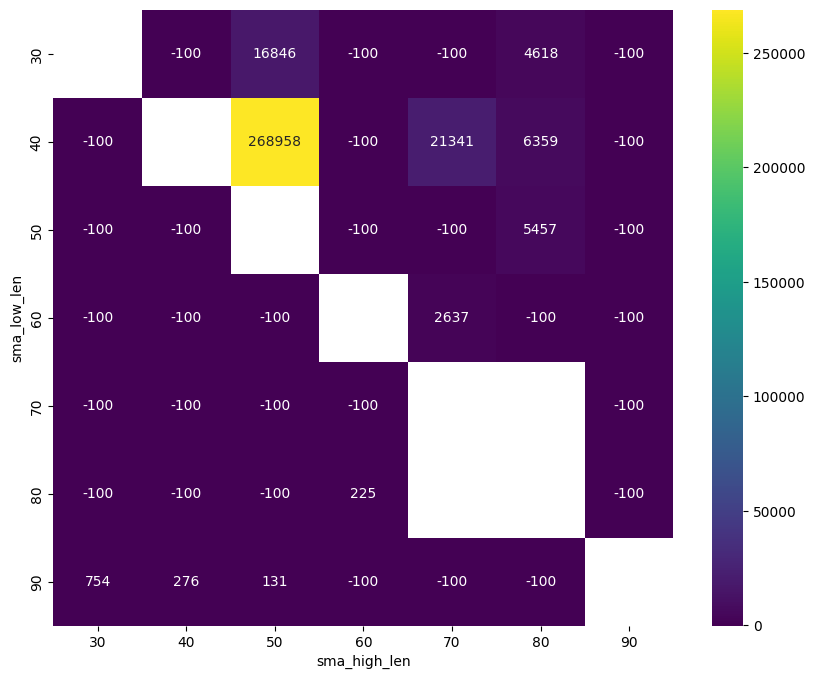

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Backtest optimization
bt = Backtest(df, MyStrat, cash=100000, margin=1/10, commission=.000)
stats, heatmap = bt.optimize(
                    sma_low_len = range(30,100,10),
                    sma_high_len = range(30,100,10),
                    maximize='Return [%]', max_tries=400,
                    random_state=0,
                    return_heatmap=True)
stats

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()